In [1]:
import json
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from joblib import Parallel, delayed
import os
import multiprocessing

from PIL import Image
from PIL import ImageFont
from sklearn.model_selection import train_test_split
from sklearn.metrics import root_mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import SGDRegressor
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.decomposition import PCA

from skimage.feature import hog
from skimage import exposure
import skimage

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.losses import MeanAbsoluteError,MeanAbsolutePercentageError
from tensorflow.keras.metrics import RootMeanSquaredError
from tensorflow.keras.models import Sequential
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.utils import plot_model
from tensorflow.keras.callbacks import History
from tensorflow.keras import layers, models, Input
from tensorflow.python.keras.callbacks import ModelCheckpoint
from tensorflow.keras.optimizers import Adam
from tensorflow import keras
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPool2D, BatchNormalization, Rescaling
from tensorflow.keras.layers import Activation, Dropout, Flatten, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from keras.applications import EfficientNetB0
from keras.applications import EfficientNetV2L
import visualkeras
from collections import defaultdict

2024-05-09 10:29:39.972454: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-05-09 10:29:39.972493: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-05-09 10:29:39.979340: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-05-09 10:29:39.987373: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


# Define train and test set

In [2]:
with open('../datasets/assignment2_dataset.json', 'r') as f:
    dataset = json.load(f)

# Split the list of dicts in train and test already.
train, test = train_test_split(dataset, test_size=0.2, random_state=11)

# Preprocessing

In [3]:
# Create a function that extracts the appid - price - screenshot from the list of dicts

def parse_json_mids(l):
    dfl = []
    for gamedata in l:
        _id = gamedata['appid']
        _price = int(gamedata['price'])/100
        _title = gamedata['title']
        _img = gamedata['screenshots']
        for screenshot in _img:
            dfl.append(
                [_id, _title, _price, screenshot]
            )
    df = pd.DataFrame(dfl)
    df.columns = ['appid', 'title', 'price', 'screenshot']
    return(df)

traindf = parse_json_mids(train)
testdf = parse_json_mids(test)

In [4]:
tdf = pd.concat([traindf, testdf])
len(tdf[tdf['price'] > 100]['appid'].unique())/len(tdf['appid'].unique())

0.00517464424320828

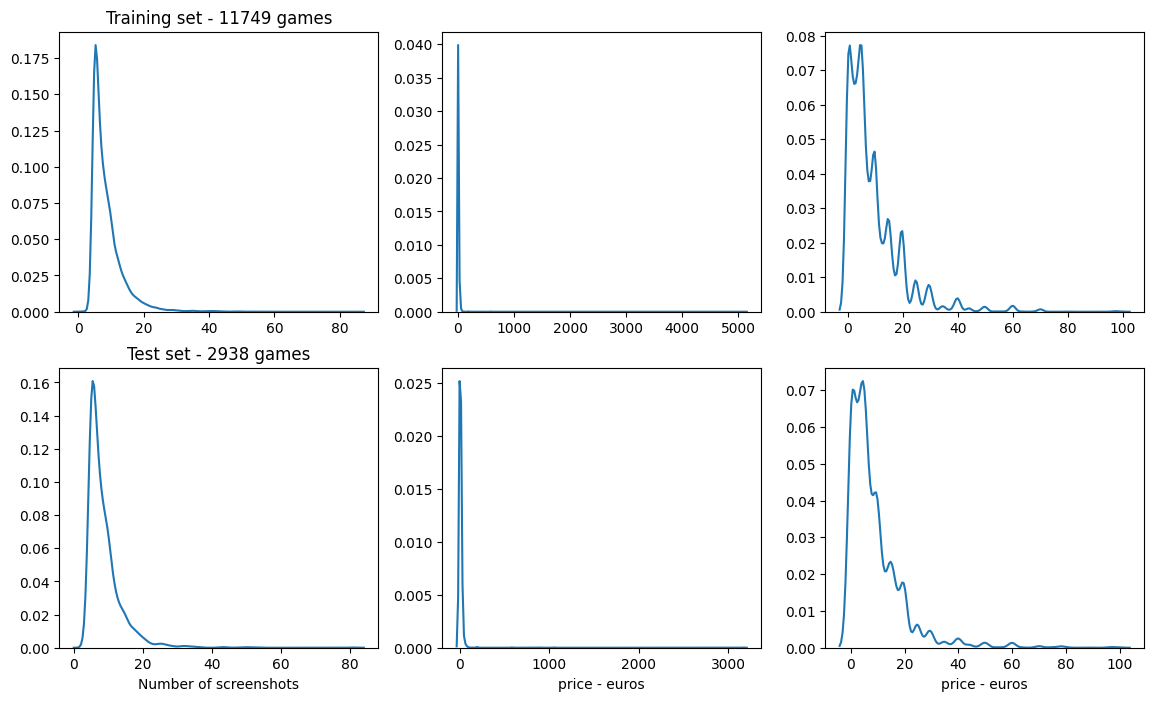

In [5]:
# Check number of screenshots per game
fig, ax = plt.subplots(nrows=2, ncols=3, figsize=(14,8))
sns.kdeplot(traindf['appid'].value_counts(), ax = ax[0,0])
ax[0,0].set_xlabel("")
ax[0,0].set_ylabel("")
ax[0,0].set_title(f"Training set - {len(traindf['appid'].unique())} games")

sns.kdeplot(testdf['appid'].value_counts(), ax = ax[1,0])
ax[1,0].set_xlabel("Number of screenshots")
ax[1,0].set_ylabel("")
ax[1,0].set_title(f"Test set - {len(testdf['appid'].unique())} games")

sns.kdeplot(traindf['price'], ax = ax[0,1])
ax[0,1].set_xlabel('')
ax[0,1].set_ylabel('')
sns.kdeplot(testdf['price'], ax = ax[1,1])
ax[1,1].set_xlabel('price - euros')
ax[1,1].set_ylabel('')

sns.kdeplot(traindf[traindf['price'] <= 100]['price'], ax = ax[0,2])
ax[0,2].set_xlabel('')
ax[0,2].set_ylabel('')
sns.kdeplot(testdf[testdf['price'] <= 100]['price'], ax = ax[1,2])
ax[1,2].set_xlabel('price - euros')
ax[1,2].set_ylabel('')
fig.savefig("../results/assignment2_dataset.png", dpi=300)

In [6]:
# Remove all the games with prices > 100
traindf = traindf[traindf['price'] <= 100]
testdf = testdf[testdf['price'] <= 100]

## Process images

In [7]:
def resize_img(_):
    IMPATH, TARGET = _
    if os.path.exists(os.path.join(TARGET, IMPATH)):
        return
    try:
        _img = Image.open(os.path.join('images', IMPATH))
    except:
        return IMPATH
    _imgresized = _img.resize((224, 224))
    _imgresized.save(os.path.join(TARGET, IMPATH), quality=50)

if not os.path.exists('images_resized'):
    os.mkdir('images_resized')
if not os.path.exists('images_resized/train'):
    os.mkdir('images_resized/train')
if not os.path.exists('images_resized/test'):
    os.mkdir('images_resized/test')

# Get screenshots in flat list
_screenshots = []
for j in testdf['screenshot'].to_list():
        _screenshots.append([j, 'images_resized/test'])

pool = multiprocessing.Pool(processes=int(os.cpu_count()/2+1))
returns = pool.map(resize_img, _screenshots)
missing_imgs = [i for i in returns if i is not None]
print(f"Missing imgs = {missing_imgs}")


Missing imgs = []


In [8]:
# Get screenshots in flat list
_screenshots = []
for j in traindf['screenshot'].to_list():
    _screenshots.append([j, 'images_resized/train'])

pool = multiprocessing.Pool(processes=int(os.cpu_count()/2+1))
returns = pool.map(resize_img, _screenshots)
missing_imgs = [i for i in returns if i is not None]
print(f"Missing imgs = {missing_imgs}")

Missing imgs = ['1029210_ss_7096afc94036153001b266a75253fb6abdd03c54.1920x1080.jpg', '1029210_ss_ddf975e414f08a0bb419818d2cd94be4ebff6db9.1920x1080.jpg', '2445340_ss_fdbf4004c0087b96c3a8ebb1152179b3563d7091.1920x1080.jpg']


In [9]:
# Remove the missing image instances from the train dataframe
traindf = traindf[~traindf['screenshot'].isin(
    [
        '1029210_ss_7096afc94036153001b266a75253fb6abdd03c54.1920x1080.jpg',
        '1029210_ss_ddf975e414f08a0bb419818d2cd94be4ebff6db9.1920x1080.jpg',
        '2445340_ss_fdbf4004c0087b96c3a8ebb1152179b3563d7091.1920x1080.jpg'
    ]
)]

# Make sure the train and testdf contain image paths now too
traindf['impath'] = 'images_resized/train/' + traindf['screenshot']
testdf['impath'] = 'images_resized/test/' + testdf['screenshot']

# Get a validation dataset that is used during model training.
traindf, valdf = train_test_split(traindf, test_size=0.2, random_state=11)

In [10]:
def get_img_stream(traindf, valdf, testdf):
    train = ImageDataGenerator(
        rescale=1.0 / 255
    )
    val = ImageDataGenerator(
        rescale = 1.0 / 255
    )
    test = ImageDataGenerator(
        rescale = 1.0 / 255
    )
    train = train.flow_from_dataframe(
        dataframe = traindf,
        x_col = 'impath',
        y_col = 'price',
        class_mode= 'raw',
        target_size=(224, 224),
        batch_size=64
    )
    val = val.flow_from_dataframe(
        dataframe = valdf,
        x_col = 'impath',
        y_col = 'price',
        class_mode= 'raw',
        target_size=(224, 224),
        batch_size=64
    )
    test = test.flow_from_dataframe(
        dataframe = testdf,
        x_col = 'impath',
        y_col = 'price',
        class_mode= 'raw',
        target_size=(224, 224),
        batch_size=64
    )

    return (train, val, test)

In [11]:
results_dic = {}

### CNN

Found 82044 validated image filenames.
Found 20512 validated image filenames.
Found 25519 validated image filenames.
Epoch 1/10


2024-05-09 21:31:29.094983: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_1/dropout_4/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


1282/1282 [==============================] - ETA: 0s - loss: 16.9319 - mean_absolute_error: 16.9314 - mean_absolute_percentage_error: 1327047552.0000 - root_mean_squared_error: 295.7603
Epoch 1: val_mean_absolute_error improved from inf to 9.02772, saving model to cnn.keras
1282/1282 [==============================] - 960s 747ms/step - loss: 16.9319 - mean_absolute_error: 16.9314 - mean_absolute_percentage_error: 1327047552.0000 - root_mean_squared_error: 295.7603 - val_loss: 9.0269 - val_mean_absolute_error: 9.0277 - val_mean_absolute_percentage_error: 86.4632 - val_root_mean_squared_error: 13.6525
Epoch 2/10
1282/1282 [==============================] - ETA: 0s - loss: 8.9628 - mean_absolute_error: 8.9627 - mean_absolute_percentage_error: 86.7911 - root_mean_squared_error: 13.4086
Epoch 2: val_mean_absolute_error improved from 9.02772 to 9.02460, saving model to cnn.keras
1282/1282 [==============================] - 967s 754ms/step - loss: 8.9628 - mean_absolute_error: 8.9627 - mean_a

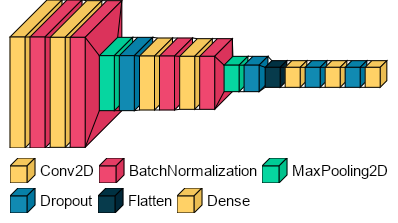

399/399 [==============================] - 29s 72ms/step
CNN: mae=8.907073974609375, mape=85.27893829345703, rmse=13.71914005279541


In [35]:
if not os.path.exists('cnn.keras'):
    train, val, test = get_img_stream(traindf, valdf, testdf)
    model_cnn = Sequential()
    model_cnn.add(
        Conv2D(
            filters = 16,
            kernel_size = (3, 3),
            activation='relu',
            input_shape = (224, 224, 3)
        )
    )
    model_cnn.add(BatchNormalization())
    model_cnn.add(Conv2D(filters = 16, kernel_size = (3, 3), activation='relu'))
    model_cnn.add(BatchNormalization())
    model_cnn.add(MaxPool2D(strides=(2,2)))
    model_cnn.add(Dropout(0.25))
    model_cnn.add(Conv2D(filters = 32, kernel_size = (3, 3), activation='relu'))
    model_cnn.add(BatchNormalization())
    model_cnn.add(Conv2D(filters = 32, kernel_size = (3, 3), activation='relu'))
    model_cnn.add(BatchNormalization())
    model_cnn.add(MaxPool2D(strides=(2,2)))
    model_cnn.add(Dropout(0.25))
    model_cnn.add(Flatten())
    model_cnn.add(Dense(512, activation='relu'))
    model_cnn.add(Dropout(0.25))
    model_cnn.add(Dense(1024, activation='relu'))
    model_cnn.add(Dropout(0.4))
    model_cnn.add(Dense(1, activation='relu'))
    model_cnn.compile(
        loss="mean_absolute_error",
        metrics=[MeanAbsoluteError(), MeanAbsolutePercentageError(), RootMeanSquaredError()],
        optimizer=Adam(0.01)
    )
    callback = ModelCheckpoint(
        "cnn.keras",
        monitor='val_mean_absolute_error',
        verbose=1,
        save_best_only=True,
        save_weights_only=False,
        mode='min'
    )
    
    history_cnn = model_cnn.fit(
        train,
        epochs=10,
        validation_data=val,
        callbacks=callback
    )
else:
    model_cnn = tf.keras.models.load_model('cnn.keras')


font = ImageFont.truetype("arial.ttf", 15)
visualkeras.layered_view(
    model_cnn,
    scale_xy=0.5,
    max_z=15,
    font=font,
    legend=True,
    draw_volume=True,
    spacing=5,
    to_file='../results/assignment2_cnn.png'
).show()
    
loss, mae, mape, rmse = model_cnn.evaluate(
    test,
    callbacks=callback
)

results_dic['cnn'] = {
    'MAE': mae,
    'MAPE': mape,
    'RMSE': rmse
}
testdf['price_cnn'] = model_cnn.predict(test)

print(f"CNN: mae={mae}, mape={mape}, rmse={rmse}")


### EfficientNetV2B0

Found 82044 validated image filenames.
Found 20512 validated image filenames.
Found 25519 validated image filenames.
Epoch 1/10
1282/1282 [==============================] - ETA: 0s - loss: 6.6862 - mean_absolute_error: 6.6862 - mean_absolute_percentage_error: 795176256.0000 - root_mean_squared_error: 10.5364
Epoch 1: val_mean_absolute_error improved from inf to 6.61591, saving model to efficientnet.keras
1282/1282 [==============================] - 195s 149ms/step - loss: 6.6862 - mean_absolute_error: 6.6862 - mean_absolute_percentage_error: 795176256.0000 - root_mean_squared_error: 10.5364 - val_loss: 6.6147 - val_mean_absolute_error: 6.6159 - val_mean_absolute_percentage_error: 769862528.0000 - val_root_mean_squared_error: 10.7680
Epoch 2/10
1282/1282 [==============================] - ETA: 0s - loss: 6.5898 - mean_absolute_error: 6.5898 - mean_absolute_percentage_error: 773284352.0000 - root_mean_squared_error: 10.4944
Epoch 2: val_mean_absolute_error did not improve from 6.61591
12

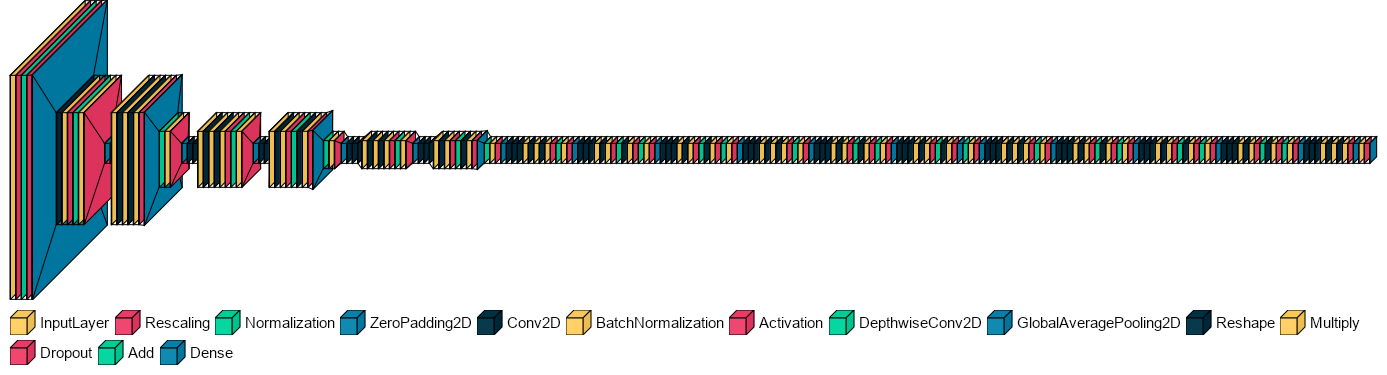

399/399 [==============================] - 46s 113ms/step
Effnet: mae=6.561142444610596, mape=884551488.0, rmse=10.829690933227539


In [36]:
if not os.path.exists('efficientnet.keras'):
    train, val, test = get_img_stream(traindf, valdf, testdf)
    inputs = Input(shape=(224, 224, 3))
    model_effnet = EfficientNetB0(include_top=False, input_tensor=inputs, weights='imagenet')
    model_effnet.trainable = False
    x = layers.GlobalAveragePooling2D(name="avg_pool")(model_effnet.output)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.4, name="top_dropout")(x)
    outputs = layers.Dense(1, name="pred")(x)
    model_effnet = keras.Model(inputs, outputs, name="EfficientNetB0")
    model_effnet.compile(
        loss="mean_absolute_error",
        metrics=[MeanAbsoluteError(), MeanAbsolutePercentageError(), RootMeanSquaredError()],
        optimizer=Adam(0.01)
    )
    callback = ModelCheckpoint(
        "efficientnet.keras",
        monitor='val_mean_absolute_error',
        verbose=1,
        save_best_only=True,
        save_weights_only=False,
        mode='min'
    )
    history_effnet = model_effnet.fit(
        train,
        epochs=10,
        validation_data=val,
        callbacks=callback
    )
else:
    model_effnet = tf.keras.models.load_model('efficientnet.keras')

# Visualize model
visualkeras.layered_view(
    model_effnet,
    scale_xy=1,
    max_z=0.5,
    font=font,
    legend=True,
    draw_volume=True,
    spacing=5,
    to_file='../results/assignment2_efficientnet.png'
).show()

loss, mae, mape, rmse = model_effnet.evaluate(
    test,
    callbacks=callback
)

results_dic['effnet'] = {
    'MAE': mae,
    'MAPE': mape,
    'RMSE': rmse
}
testdf['price_effnet'] = model_effnet.predict(test)

print(f"Effnet: mae={mae}, mape={mape}, rmse={rmse}")


In [37]:
if not os.path.exists('efficientnetV2L.keras'):
    train, val, test = get_img_stream(traindf, valdf, testdf)
    inputs = Input(shape=(224, 224, 3))
    model_effnetV2L = EfficientNetV2L(include_top=False, input_tensor=inputs, weights='imagenet')
    model_effnetV2L.trainable = False
    x = layers.GlobalAveragePooling2D(name="avg_pool")(model_effnetV2L.output)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.4, name="top_dropout")(x)
    outputs = layers.Dense(1, name="pred")(x)
    model_effnetV2L = keras.Model(inputs, outputs, name="model_effnetV2L")
    model_effnetV2L.compile(
        loss="mean_absolute_error",
        metrics=[MeanAbsoluteError(), MeanAbsolutePercentageError(), RootMeanSquaredError()],
        optimizer=Adam(0.01)
    )
    callback = ModelCheckpoint(
        "efficientnetV2L.keras",
        monitor='val_mean_absolute_error',
        verbose=1,
        save_best_only=True,
        save_weights_only=False,
        mode='min'
    )
    history_effnetV2L = model_effnetV2L.fit(
        train,
        epochs=10,
        validation_data=val,
        callbacks=callback
    )
else:
    model_effnetV2L = tf.keras.models.load_model('efficientnetV2L.keras')

visualkeras.layered_view(
    model_effnetV2L,
    scale_xy=1,
    max_z=0.5,
    font=font,
    legend=True,
    draw_volume=True,
    spacing=5,
    to_file='results/assignment2_efficientnet2VL.png'
).show()

loss, mae, mape, rmse = model_effnetV2L.evaluate(
    test,
    callbacks=callback
)

results_dic['effnetV2L'] = {
    'MAE': mae,
    'MAPE': mape,
    'RMSE': rmse
}
testdf['price_effnetV2L'] = model_effnetV2L.predict(test)

print(f"EffnetV2L: mae={mae}, mape={mape}, rmse={rmse}")


Found 82044 validated image filenames.
Found 20512 validated image filenames.
Found 25519 validated image filenames.
Epoch 1/10
1282/1282 [==============================] - ETA: 0s - loss: 6.6996 - mean_absolute_error: 6.6996 - mean_absolute_percentage_error: 819824000.0000 - root_mean_squared_error: 10.4703
Epoch 1: val_mean_absolute_error improved from inf to 6.57107, saving model to efficientnetV2L.keras
1282/1282 [==============================] - 1116s 859ms/step - loss: 6.6996 - mean_absolute_error: 6.6996 - mean_absolute_percentage_error: 819824000.0000 - root_mean_squared_error: 10.4703 - val_loss: 6.5740 - val_mean_absolute_error: 6.5711 - val_mean_absolute_percentage_error: 864868992.0000 - val_root_mean_squared_error: 10.4929
Epoch 2/10
1282/1282 [==============================] - ETA: 0s - loss: 6.5783 - mean_absolute_error: 6.5783 - mean_absolute_percentage_error: 797207552.0000 - root_mean_squared_error: 10.4105
Epoch 2: val_mean_absolute_error improved from 6.57107 to 6.

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



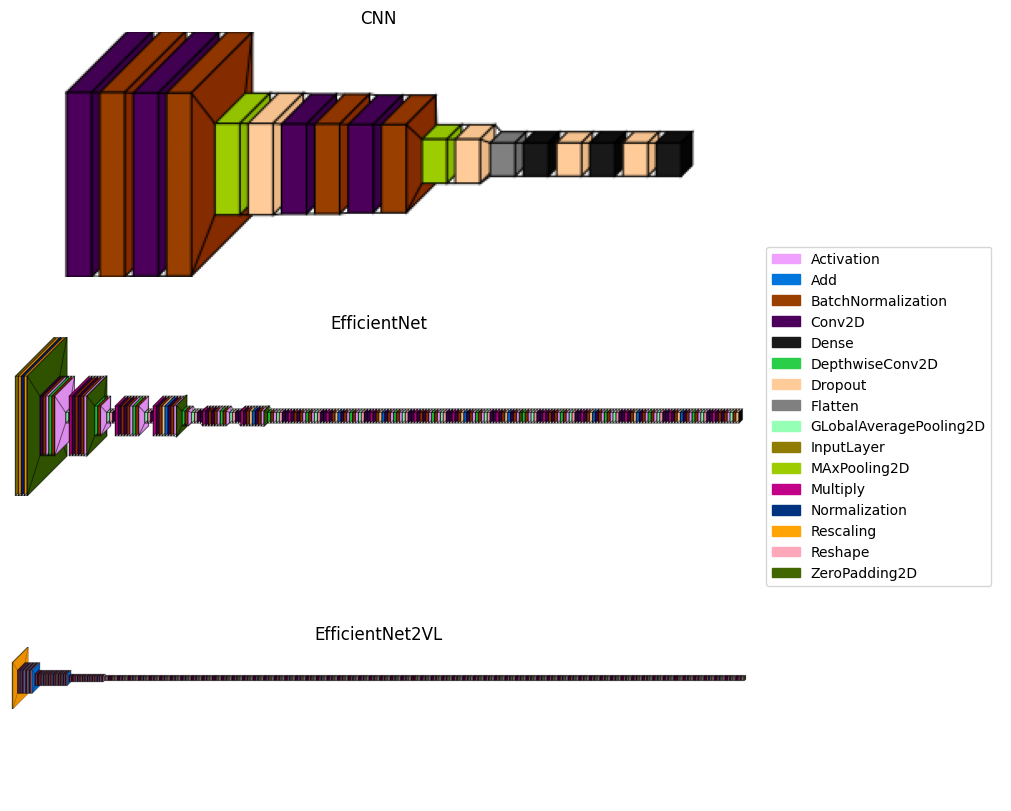

In [38]:
# Combine the architectures in 1 image.
from tensorflow.keras.layers import Activation, Add, BatchNormalization, Conv2D, Dense, DepthwiseConv2D, Dropout, Flatten, GlobalAveragePooling2D, InputLayer
from tensorflow.keras.layers import MaxPooling2D, Multiply, Normalization, Rescaling, Reshape, ZeroPadding2D

# dict to have proper mapping across all images
cmap = defaultdict(dict)
cmap[Activation]['fill'] = "#F0A0FF"
cmap[Add]['fill'] = "#0075DC"
cmap[BatchNormalization]['fill'] ="#993F00"
cmap[Conv2D]['fill'] = "#4C005C"
cmap[Dense]['fill'] ="#191919"
cmap[DepthwiseConv2D]['fill'] = "#2BCE48"
cmap[Dropout]['fill'] = "#FFCC99"
cmap[Flatten]['fill'] ="#808080"
cmap[GlobalAveragePooling2D]['fill'] ="#94FFB5"
cmap[InputLayer]['fill'] ="#8F7C00"
cmap[MaxPooling2D]['fill'] = "#9DCC00"
cmap[Multiply]['fill'] = "#C20088"
cmap[Normalization]['fill'] = "#003380"
cmap[Rescaling]['fill'] ="#FFA405"
cmap[Reshape]['fill'] = "#FFA8BB"
cmap[ZeroPadding2D]['fill'] = "#426600"

visualkeras.layered_view(
    model_cnn,
    scale_xy=0.5,
    max_z=15,
    font=font,
    legend=False,
    draw_volume=True,
    spacing=5,
    to_file='cnn.png',
    color_map=cmap
)

visualkeras.layered_view(
    model_effnet,
    scale_xy=1,
    max_z=0.5,
    font=font,
    legend=False,
    draw_volume=True,
    spacing=5,
    to_file='../results/assignment2_efficientnet.png',
    color_map=cmap
)


visualkeras.layered_view(
    model_effnetV2L,
    scale_xy=1,
    max_z=0.4,
    font=font,
    legend=False,
    draw_volume=True,
    spacing=3,
    to_file='../results/assignment2_efficientnet2VL.png',
    color_map=cmap
)

# Load imgs in mpl object
imcnn = mpimg.imread('cnn.png')
imeff = mpimg.imread('efficientnet.png')
im2vl = mpimg.imread('efficientnet2VL.png')

cmap[Dense]['fill'] ="#191919"
cmap[DepthwiseConv2D]['fill'] = "#2BCE48"
cmap[Dropout]['fill'] = "#FFCC99"
cmap[Flatten]['fill'] ="#808080"
cmap[GlobalAveragePooling2D]['fill'] ="#94FFB5"
cmap[InputLayer]['fill'] ="#8F7C00"
cmap[MaxPooling2D]['fill'] = "#9DCC00"
cmap[Multiply]['fill'] = "#C20088"
cmap[Normalization]['fill'] = "#003380"
cmap[Rescaling]['fill'] ="#FFA405"
cmap[Reshape]['fill'] = "#FFA8BB"
cmap[ZeroPadding2D]['fill'] = "#426600"

_c = [
    "#F0A0FF","#0075DC","#993F00","#4C005C",
    "#191919","#2BCE48","#FFCC99","#808080",
    "#94FFB5","#8F7C00", "#9DCC00","#C20088",
    "#003380","#FFA405", "#FFA8BB", "#426600"
]
_l = [
    "Activation", "Add", "BatchNormalization", "Conv2D",
    "Dense", "DepthwiseConv2D", "Dropout", "Flatten",
    "GLobalAveragePooling2D", "InputLayer", "MAxPooling2D", "Multiply", 
    "Normalization", "Rescaling", "Reshape","ZeroPadding2D"
]

fig = plt.figure(constrained_layout=True, figsize=(10,8))
gs = fig.add_gridspec(3,4)
ax_cnn = fig.add_subplot(gs[0, 0:3])
ax_eff = fig.add_subplot(gs[1, 0:3])
ax_2vl = fig.add_subplot(gs[2, 0:3])
ax_l = fig.add_subplot(gs[0:3, 3])

ax_cnn.imshow(imcnn, aspect='equal')
ax_cnn.axis('off')
ax_cnn.set_title('CNN')
ax_eff.imshow(imeff)
ax_eff.axis('off')
ax_eff.set_title('EfficientNet')
ax_2vl.imshow(im2vl)
ax_2vl.axis('off')
ax_2vl.set_title('EfficientNet2VL')
# Legend
palette = dict(zip(_l, _c))
handles = [matplotlib.patches.Patch(color=palette[x], label=x) for x in palette.keys()]
ax_l.legend(handles=handles, loc='center')
ax_l.axis('off')

fig.savefig("../results/assignment2_Architecture.png", dpi=300)

### SGDregression & Gradient boosting

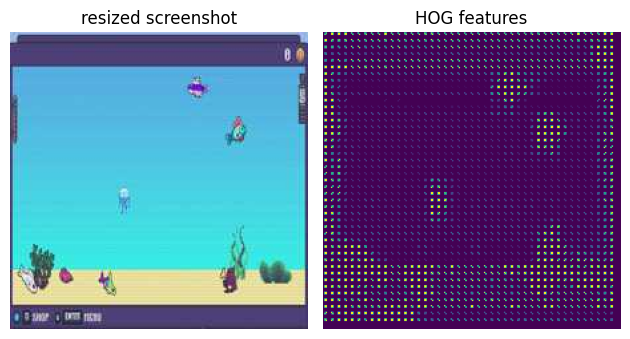

In [39]:
# Example on hog features
fig, ax = plt.subplots(ncols=2)
ax[0].imshow( load_img(traindf.iloc[790, 4]))
ax[0].set_title("resized screenshot")
ax[0].axis('off')
fd, hogexample = hog(
    img_to_array(load_img(traindf.iloc[790, 4])),
    orientations=8,
    pixels_per_cell=(5,5),
    cells_per_block=(1,1),
    visualize=True,
    channel_axis=-1
)
hogexample = exposure.rescale_intensity(hogexample, in_range=(0,10))
ax[1].imshow(hogexample)
ax[1].axis('off')
ax[1].set_title("HOG features")
plt.tight_layout()
fig.savefig('../results/assignment2_hogexample.png', dpi=300)

In [40]:
def _h(i):
    return hog(
        img_to_array(load_img(i)),
        orientations=8,
        pixels_per_cell=(5, 5),
        cells_per_block=(1, 1),
        visualize=False,
        feature_vector=True,
        channel_axis=-1
    )
def extract_hog_features(impaths):
    hogs = Parallel(n_jobs=10)(delayed(_h)(i) for i in impaths)
    return np.vstack(hogs)
    
if not os.path.exists('testhogs.npy'):
    testhogs = extract_hog_features(testdf['impath'].tolist())
    np.save('testhogs.npy', testhogs, allow_pickle=True)
else:
    testhogs = np.load('testhogs.npy')
if not os.path.exists('trainhogs.npy'):
    trainhogs = extract_hog_features(traindf['impath'].tolist())
    np.save('trainhogs.npy', trainhogs, allow_pickle=True)
else:
    trainhogs = np.load('trainhogs.npy')
print(testhogs.shape)
print(trainhogs.shape)

(25519, 15488)
(82044, 15488)


In [41]:
# Perform PCA to reduce dimensionality
pca = PCA(n_components=200)
trainhogs_pca = pca.fit_transform(trainhogs)
testhogs_pca = pca.transform(testhogs)

In [42]:
#SGDreg
SGDreg = make_pipeline(
    StandardScaler(),
    SGDRegressor(max_iter=1000, tol=1e-3)
)
SGDreg.fit(trainhogs_pca, traindf['price'])
y_pred_sgdreg = SGDreg.predict(testhogs_pca)
results_dic['SGDregression'] = {
    'MAE': mean_absolute_error(testdf['price'], y_pred_sgdreg),
    'MAPE': mean_absolute_percentage_error(testdf['price'], y_pred_sgdreg),
    'RMSE': root_mean_squared_error(testdf['price'], y_pred_sgdreg)
}
testdf['price_sgdreg'] = y_pred_sgdreg

In [43]:
#gradient boosting
HGBR = make_pipeline(
    StandardScaler(),
    HistGradientBoostingRegressor()
)
HGBR.fit(trainhogs_pca, traindf['price'])
y_pred_hgbr = HGBR.predict(testhogs_pca)
results_dic['GradientBoosting'] = {
    'MAE': mean_absolute_error(testdf['price'], y_pred_hgbr),
    'MAPE': mean_absolute_percentage_error(testdf['price'], y_pred_hgbr),
    'RMSE': root_mean_squared_error(testdf['price'], y_pred_hgbr)
}
testdf['price_hgbr'] = y_pred_hgbr

### Compare results

/tmp/ipykernel_26/4041427424.py:11: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax[0].set_xticklabels(ax[0].get_xticklabels(), rotation=90)
/tmp/ipykernel_26/4041427424.py:24: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax[1].set_xticklabels(ax[1].get_xticklabels(), rotation=90)
/tmp/ipykernel_26/4041427424.py:37: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax[2].set_xticklabels(ax[2].get_xticklabels(), rotation=90)


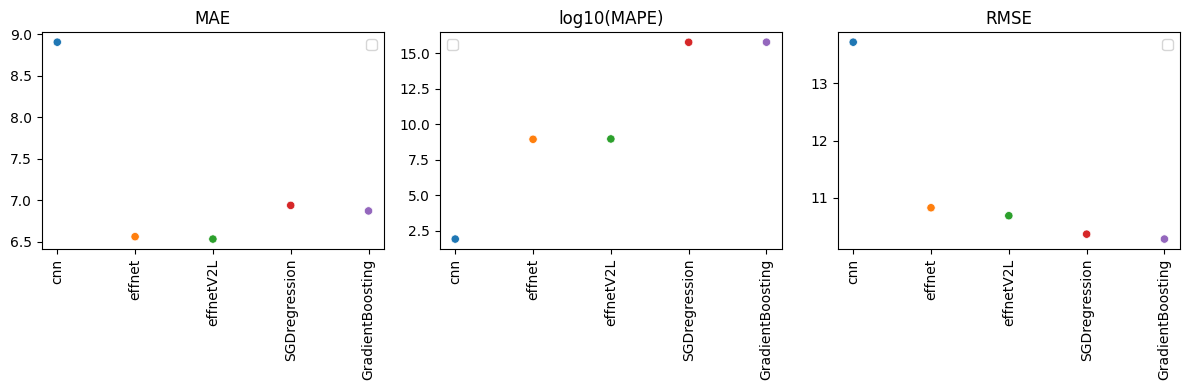

In [87]:
resdf = pd.DataFrame(results_dic).T
fig, ax = plt.subplots(ncols=3, sharex=True, figsize=(12,4))
sns.scatterplot(
    data=resdf,
    x=resdf.index,
    y=resdf['MAE'],
    hue=resdf.index,
    ax=ax[0]
)
ax[0].legend([])
ax[0].set_xticklabels(ax[0].get_xticklabels(), rotation=90)
ax[0].set_title('MAE')
ax[0].set_ylabel('')
ax[0].set_xlabel('')

sns.scatterplot(
    data=resdf,
    x=resdf.index,
    y=np.log10(resdf['MAPE']),
    hue=resdf.index,
    ax=ax[1]
)
ax[1].legend([])
ax[1].set_xticklabels(ax[1].get_xticklabels(), rotation=90)
ax[1].set_title('log10(MAPE)')
ax[1].set_ylabel('')
ax[1].set_xlabel('')

sns.scatterplot(
    data=resdf,
    x=resdf.index,
    y=resdf['RMSE'],
    hue=resdf.index,
    ax=ax[2]
)
ax[2].legend([])
ax[2].set_xticklabels(ax[2].get_xticklabels(), rotation=90)
ax[2].set_title('RMSE')
ax[2].set_ylabel('')
ax[2].set_xlabel('')
plt.tight_layout()
plt.savefig('../results/assignment2_errors.png', dpi=300)

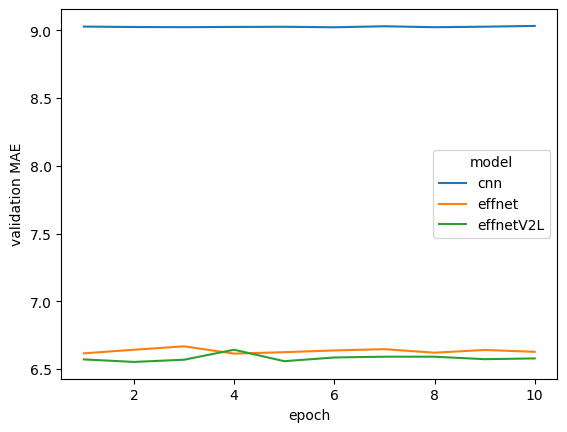

In [88]:
fittingdf = pd.DataFrame(
    [
        history_cnn.history['val_mean_absolute_error'],
        history_effnet.history['val_mean_absolute_error'],
        history_effnetV2L.history['val_mean_absolute_error']
    ],
    index=['cnn', 'effnet', 'effnetV2L']
).T
fittingdf['epoch'] = fittingdf.index + 1
fittingdf = fittingdf.melt(id_vars='epoch')
fittingdf.columns = ['epoch', 'model', 'val_MAE']
g = sns.lineplot(
    data=fittingdf,
    x='epoch',
    y=fittingdf['val_MAE'],
    hue='model'
)
g.set_ylabel('validation MAE')
fig.savefig('../results/assignment2_trainingloss.png', dpi=300)

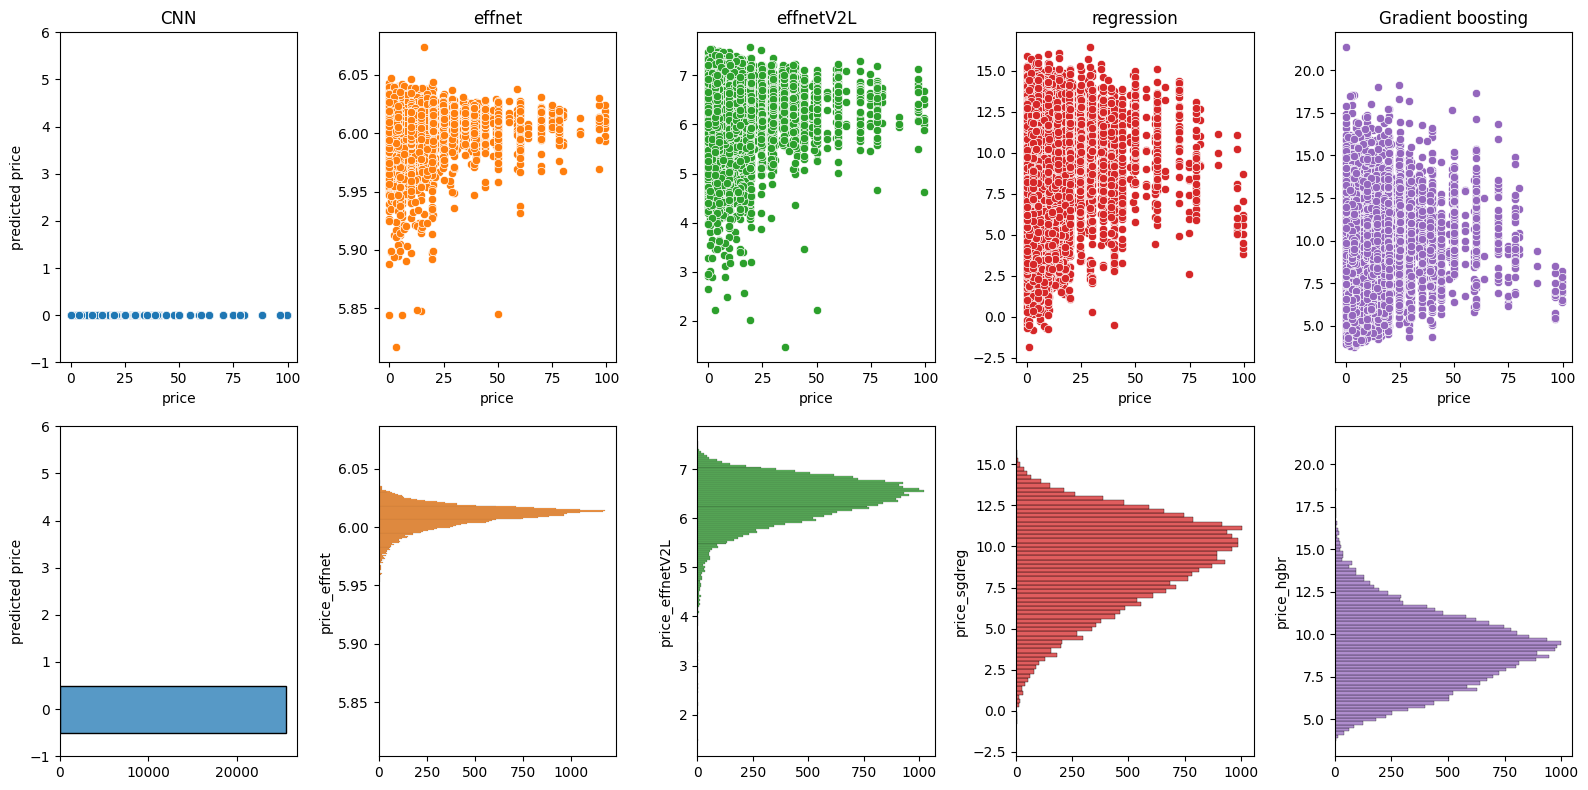

In [98]:
fig, ax = plt.subplots(ncols=5, nrows=2, figsize=(16,8), sharey = 'col')
sns.scatterplot(
     data=testdf,
     x='price',
     y='price_cnn',
    ax=ax[0,0]
)
ax[0,0].set_ylabel('predicted price')
ax[0,0].set_title("CNN")
sns.scatterplot(
     data=testdf,
     x='price',
     y='price_effnet',
    ax=ax[0,1],
    c='#ff7f0e'
)
ax[0,1].set_title("effnet")
ax[0,1].set_ylabel('')
sns.scatterplot(
     data=testdf,
     x='price',
     y='price_effnetV2L',
    ax=ax[0,2],
    c='#2ca02c'
)
ax[0,2].set_title("effnetV2L")
ax[0,2].set_ylabel('')
sns.scatterplot(
     data=testdf,
     x='price',
     y='price_sgdreg',
    ax=ax[0,3],
    c='#d62728'
)
ax[0,3].set_title("regression")
ax[0,3].set_ylabel('')
sns.scatterplot(
     data=testdf,
     x='price',
     y='price_hgbr',
    ax=ax[0,4],
    c='#9467bd'
)
ax[0,4].set_title("Gradient boosting")
ax[0,4].set_ylabel('')

sns.histplot(
    data=testdf,
    y='price_cnn',
    ax=ax[1,0]
)
ax[1,0].set_ylabel('predicted price')
ax[1,0].set_xlabel('')
ax[1,0].set_ylim(-1,6)
sns.histplot(
    data=testdf,
    y='price_effnet',
    ax=ax[1,1],
    color='#ff7f0e'
)
ax[1,1].set_xlabel('')
sns.histplot(
    data=testdf,
    y='price_effnetV2L',
    ax=ax[1,2],
    color='#2ca02c'
)
ax[1,2].set_xlabel('')
sns.histplot(
    data=testdf,
    y='price_sgdreg',
    ax=ax[1,3],
    color='#d62728'
)
ax[1,3].set_xlabel('')
sns.histplot(
    data=testdf,
    y='price_hgbr',
    ax=ax[1,4],
    color='#9467bd'
)
ax[1,4].set_xlabel('')
plt.tight_layout()
fig.savefig("../results/assignment2_preds.png", dpi=300)